In [5]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt

# Load data
url = 'https://drive.google.com/uc?id={}'.format('1OxJ30RWe888XNourwTgYPg0medXaQ_ow')
data = pd.read_csv(url)
data.dropna(inplace=True)

# Assume 'sentiment' column is your target and 'text' is your feature column
data_0 = data[data['sentiment'] == 0].sample(n=512, random_state=42)
data_1 = data[data['sentiment'] == 1].sample(n=512, random_state=42)
data_balanced = pd.concat([data_0, data_1]).sample(frac=1, random_state=42)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ber

Average training loss: 0.70
Average training loss: 0.54
Average training loss: 0.31
Average training loss: 0.11
Average training loss: 0.04
              precision    recall  f1-score   support

           0       0.76      0.83      0.79        53
           1       0.80      0.72      0.76        50

    accuracy                           0.78       103
   macro avg       0.78      0.78      0.78       103
weighted avg       0.78      0.78      0.78       103

[[44  9]
 [14 36]]
ROC-AUC: 0.7750943396226415


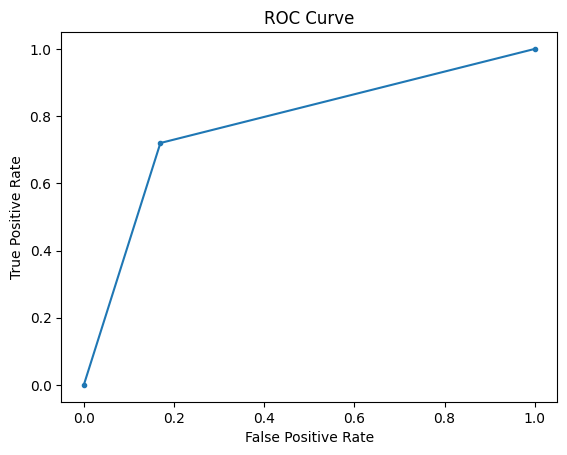

In [7]:
# Split the data
train_data, test_data = train_test_split(data_balanced, test_size=0.1, random_state=42)

# Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_data(data):
    input_ids = []
    attention_masks = []

    for sent in data:
        encoded_dict = tokenizer.encode_plus(
            sent,
            add_special_tokens=True,
            max_length=128,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    return torch.cat(input_ids, dim=0), torch.cat(attention_masks, dim=0)

# Prepare train and test data
train_inputs, train_masks = tokenize_data(train_data['text'])
train_labels = torch.tensor(train_data['sentiment'].values)
test_inputs, test_masks = tokenize_data(test_data['text'])
test_labels = torch.tensor(test_data['sentiment'].values)

# DataLoader
batch_size = 16

train_dataset = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)

test_dataset = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=batch_size)

# Model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Training loop
epochs = 5
for epoch in range(epochs):
    model.train()
    model.cuda()
    total_loss = 0

    for step, batch in enumerate(train_dataloader):
        batch = [r.cuda() for r in batch]
        b_input_ids, b_input_mask, b_labels = batch

        model.zero_grad()

        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

        loss = outputs[0]
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Average training loss: {avg_train_loss:.2f}")

# Evaluation
def evaluate_model(model, dataloader):
    model.eval()
    predictions, true_labels = [], []

    for batch in dataloader:
        batch = [t.cuda() for t in batch]
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

        logits = outputs[0]
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        predictions.append(logits)
        true_labels.append(label_ids)

    predictions = np.concatenate(predictions, axis=0)
    predictions = np.argmax(predictions, axis=1)
    true_labels = np.concatenate(true_labels)

    return true_labels, predictions

true_labels, predictions = evaluate_model(model, test_dataloader)

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# Evaluation
print(classification_report(true_labels, predictions))
print(confusion_matrix(true_labels, predictions))

# ROC-AUC
roc_auc = roc_auc_score(true_labels, predictions)
print(f'ROC-AUC: {roc_auc}')

# Plot ROC Curve
fpr, tpr, _ = roc_curve(true_labels, predictions)
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()